In [2]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

from pydrake.all import (
    Concatenate,
    ConstantVectorSource,
    DiagramBuilder,
    InverseKinematics,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    PiecewisePolynomial,
    PiecewiseQuaternionSlerp,
    PointCloud,
    RigidTransform,
    LogVectorOutput,
    RollPitchYaw,
    RotationMatrix,
    Simulator,
    Solve,
    StartMeshcat,
    TrajectorySource,
    CollisionFilterDeclaration,
    GeometrySet,
    CollisionFilterManager
)
from pydrake.multibody import inverse_kinematics
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.trajectories import PiecewisePolynomial
from scipy.spatial import KDTree

from manipulation import FindResource
from manipulation.meshcat_utils import AddMeshcatTriad, MeshcatPoseSliders
from manipulation.scenarios import AddIiwa, AddWsg, AddMultibodyTriad, MakeManipulationStation, AddRgbdSensors
from manipulation.station import AddPointClouds, load_scenario, MakeHardwareStation
from manipulation.utils import running_as_notebook, ConfigureParser

In [4]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [76]:
meshcat.Delete()

In [5]:
def CreateIiwaControllerPlant():
    """creates plant that includes only the robot and gripper, used for controllers."""

    sim_timestep = 1e-3
    plant_robot = MultibodyPlant(sim_timestep)
    parser = Parser(plant=plant_robot)

    parser.AddModelsFromUrl("file:///workspaces/manip-final-project/controller_file.dmd.yaml")
    
    plant_robot.mutable_gravity_field().set_gravity_vector([0, 0, 0])
    plant_robot.Finalize()

    link_frame_indices = []
    for i in range(8):
        link_frame_indices.append(
            plant_robot.GetFrameByName("iiwa_link_" + str(i)).index()
        )

    return plant_robot, link_frame_indices

def BuildAndSimulateTrajectory(q_traj, g_traj, duration=0.01):
    """Simulate trajectory for manipulation station.
    @param q_traj: Trajectory class used to initialize TrajectorySource for joints.
    @param g_traj: Trajectory class used to initialize TrajectorySource for gripper.
    """
    builder = DiagramBuilder()
    scenario = load_scenario(
        filename = "/workspaces/manip-final-project/withcamera.scenarios.yaml",
        scenario_name = "Tennis"
    )
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))
    plant = station.GetSubsystemByName("plant")
    scene_graph = station.GetSubsystemByName("scene_graph")
    
    wsg1 = plant.GetModelInstanceByName("wsg1")
    wsg2 = plant.GetModelInstanceByName("wsg2")

    AddMultibodyTriad(plant.GetFrameByName("body", wsg1), scene_graph)
    AddMultibodyTriad(plant.GetFrameByName("body", wsg2), scene_graph)

    q_traj_system = builder.AddSystem(TrajectorySource(q_traj))
    g_traj_system1 = builder.AddSystem(TrajectorySource(g_traj))
    g_traj_system2 = builder.AddSystem(TrajectorySource(g_traj))

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder,
        station.GetOutputPort("query_object"),
        meshcat,
        MeshcatVisualizerParams(delete_on_initialization_event=False),
    )

    builder.Connect(
        q_traj_system.get_output_port(), station.GetInputPort("iiwa.position")
    )
    
    builder.Connect(
        g_traj_system1.get_output_port(), station.GetInputPort("wsg1.position")
    )
    builder.Connect(
        g_traj_system2.get_output_port(), station.GetInputPort("wsg2.position")
    )
    
    body1 = plant.GetBodyByName("body", wsg1)
    body2 = plant.GetBodyByName("body", wsg2)
    
    left1 = plant.GetBodyByName("left_finger", wsg1)
    left2 = plant.GetBodyByName("left_finger", wsg2)
    right1 = plant.GetBodyByName("right_finger", wsg1)
    right2 = plant.GetBodyByName("right_finger", wsg2)

    geometry_wsg1 = plant.GetCollisionGeometriesForBody(body1)[0]
    geometry_wsg2 = plant.GetCollisionGeometriesForBody(body2)[0]
    geometry_left1 = plant.GetCollisionGeometriesForBody(left1)[0]
    geometry_left2 = plant.GetCollisionGeometriesForBody(left2)[0]
    geometry_right1 = plant.GetCollisionGeometriesForBody(right1)[0]
    geometry_right2 = plant.GetCollisionGeometriesForBody(right2)[0]
    
    geometries1 = GeometrySet()
    geometries1.Add(geometry_wsg1)
    geometries1.Add(geometry_left1)
    geometries1.Add(geometry_right1)
    
    geometries2 = GeometrySet()
    geometries2.Add(geometry_wsg2)
    geometries2.Add(geometry_left2)
    geometries2.Add(geometry_right2)
    
    collision_filter = CollisionFilterDeclaration()
    
    collision_filter.ExcludeBetween(geometries1, geometries2)

    manager = scene_graph.collision_filter_manager()
    manager.Apply(collision_filter)

    diagram = builder.Build()

    simulator = Simulator(diagram)
    visualizer.StartRecording(False)
    simulator.AdvanceTo(duration)
    visualizer.PublishRecording()

    return simulator, plant

def setup_manipulation_station():
    builder = DiagramBuilder()
    scenario = load_scenario(
        filename = "/workspaces/manip-final-project/withcamera.scenarios.yaml",
        scenario_name = "Tennis"
    )
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))
    plant = station.GetSubsystemByName("plant")
    scene_graph = station.GetSubsystemByName("scene_graph")
    to_point_cloud = AddPointClouds(
        scenario=scenario, station=station, builder=builder, meshcat=meshcat
    )
    for i in range(2):
        camera_name = f"camera{i}"

        builder.ExportOutput(
            station.GetOutputPort(camera_name + ".rgb_image"), f"rgb_image{i}"
        )
        builder.ExportOutput(
            station.GetOutputPort(camera_name + ".depth_image"), f"depth_image{i}"
        )

        # Add a box for the camera in the environment.
        
        camera_instance = plant.GetModelInstanceByName(camera_name)
        AddMultibodyTriad(
            plant.GetFrameByName("base", camera_instance),
            scene_graph,
            length=0.1,
            radius=0.005,
        )
        # Export the point cloud output.
        builder.ExportOutput(
            to_point_cloud[camera_name].point_cloud_output_port(), f"point_cloud{i}"
        )


    MeshcatVisualizer.AddToBuilder(
        builder,
        station.GetOutputPort("query_object"),
        meshcat,
        MeshcatVisualizerParams(delete_on_initialization_event=False),
    )

    wsg1_position = builder.AddSystem(ConstantVectorSource([0.1]))
    builder.Connect(
        wsg1_position.get_output_port(), station.GetInputPort("wsg1.position")
    )
    wsg2_position = builder.AddSystem(ConstantVectorSource([0.1]))
    
    builder.Connect(
        wsg2_position.get_output_port(), station.GetInputPort("wsg2.position")
    )
    wsg1 = plant.GetModelInstanceByName("wsg1")
    wsg2 = plant.GetModelInstanceByName("wsg2")
    body1 = plant.GetBodyByName("body", wsg1)
    body2 = plant.GetBodyByName("body", wsg2)
    
    left1 = plant.GetBodyByName("left_finger", wsg1)
    left2 = plant.GetBodyByName("left_finger", wsg2)
    right1 = plant.GetBodyByName("right_finger", wsg1)
    right2 = plant.GetBodyByName("right_finger", wsg2)

    geometry_wsg1 = plant.GetCollisionGeometriesForBody(body1)[0]
    geometry_wsg2 = plant.GetCollisionGeometriesForBody(body2)[0]
    geometry_left1 = plant.GetCollisionGeometriesForBody(left1)[0]
    geometry_left2 = plant.GetCollisionGeometriesForBody(left2)[0]
    geometry_right1 = plant.GetCollisionGeometriesForBody(right1)[0]
    geometry_right2 = plant.GetCollisionGeometriesForBody(right2)[0]
    
    geometries1 = GeometrySet()
    geometries1.Add(geometry_wsg1)
    geometries1.Add(geometry_left1)
    geometries1.Add(geometry_right1)
    
    geometries2 = GeometrySet()
    geometries2.Add(geometry_wsg2)
    geometries2.Add(geometry_left2)
    geometries2.Add(geometry_right2)
    
    collision_filter = CollisionFilterDeclaration()
    
    collision_filter.ExcludeBetween(geometries1, geometries2)

    manager = scene_graph.collision_filter_manager()
    manager.Apply(collision_filter)
    diagram = builder.Build()


    context = plant.CreateDefaultContext()

    initial_pose = plant.EvalBodyPoseInWorld(context, body1)
    initial_pose2 = plant.EvalBodyPoseInWorld(context, body2)

    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(0.01)

    return initial_pose, diagram, plant

initial_pose, diagram, plant = setup_manipulation_station()

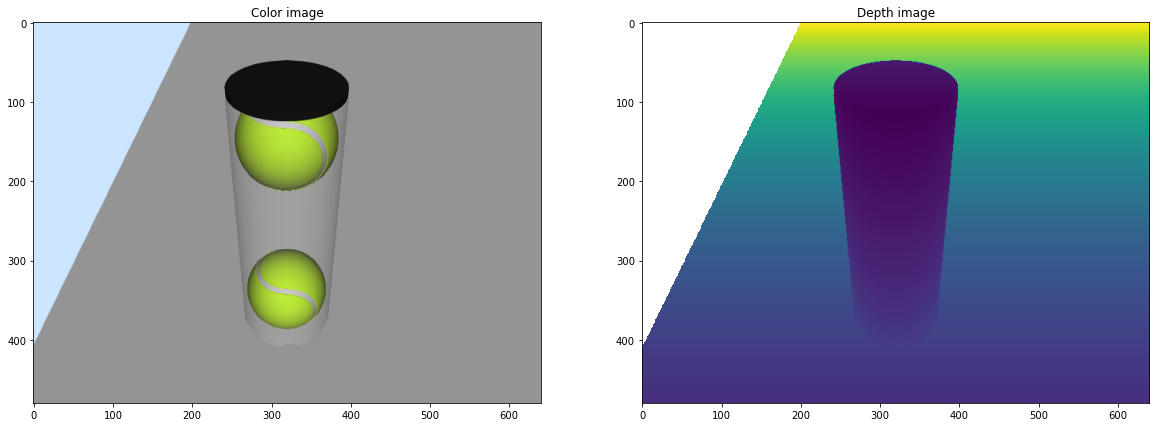

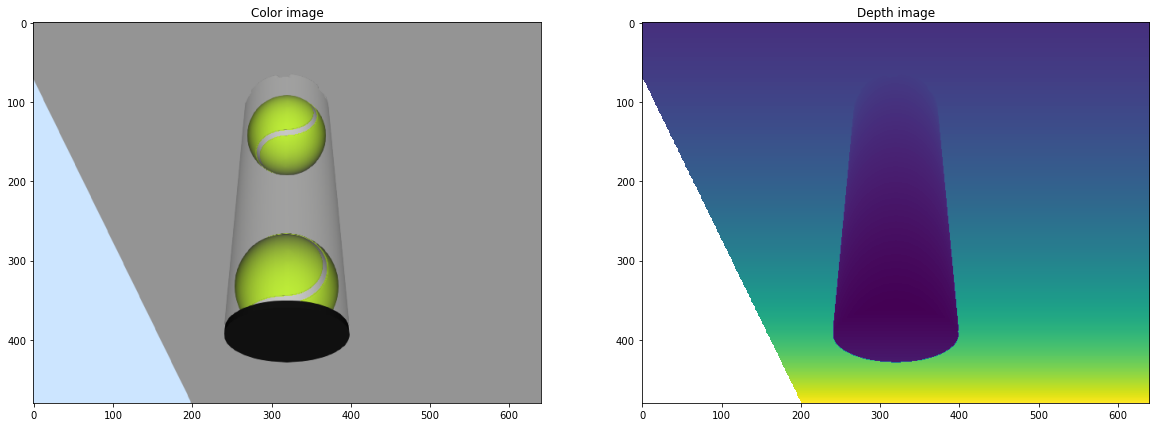

In [67]:
def plot_camera_images():
    # Evaluate the camera output ports to get the images.
    context = diagram.CreateDefaultContext()
    diagram.ForcedPublish(context)

    for i in range(2):
        color_image = diagram.GetOutputPort(f"rgb_image{i}").Eval(context)
        depth_image = diagram.GetOutputPort(f"depth_image{i}").Eval(context)

        # Plot the two images.
        plt.figure(figsize=(20, 10))
        plt.subplot(121)
        plt.imshow(color_image.data)
        plt.title("Color image")
        plt.subplot(122)
        plt.imshow(np.squeeze(depth_image.data))
        plt.title("Depth image")
        # mpld3.display()
        plt.show()

plot_camera_images()

In [68]:
def ToPointCloud(xyzs, rgbs=None):
    if rgbs:
        cloud = PointCloud(
            xyzs.shape[1], Fields(BaseField.kXYZs | BaseField.kRGBs)
        )
        cloud.mutable_rgbs()[:] = rgbs
    else:
        cloud = PointCloud(xyzs.shape[1])
    cloud.mutable_xyzs()[:] = xyzs
    return cloud

def fit_plane(xyzs):
    """
    Args:
      xyzs is (3, N) numpy array
    Returns:
      (4,) numpy array
    """
    center = np.mean(xyzs, axis=1)
    cxyzs = xyzs.T - center
    U, S, V = np.linalg.svd(cxyzs)
    normal = V[-1]  # last row of V
    d = -center.dot(normal)
    plane_equation = np.hstack([normal, d])
    return plane_equation
    
def ransac(
    point_cloud, model_fit_func, rng, tolerance=1e-3, max_iterations=500
):
    """
    Args:
      point_cloud is (3, N) numpy array
      tolerance is a float
      rng is a random number generator
      max_iterations is a (small) integer
      model_fit_func: the function to fit the model (point clouds)

    Returns:
      (4,) numpy array
    """
    best_ic = 0  # inlier count
    best_model = np.ones(4)  # plane equation ((4,) array)

    ##################
    N = point_cloud.shape[1]
    for i in range(max_iterations):
        random_int = rng.integers(low=0, high=N, size=3)
        seed_points = point_cloud[:,random_int]
        plane_equation = model_fit_func(seed_points)
        def distance_point_to_plane(point, plane_equation):
            A = plane_equation[0]
            B = plane_equation[1]
            C = plane_equation[2]
            D = plane_equation[3]

            x = point[0]
            y = point[1]
            z = point[2]

            distance = np.abs(A*x + B*y + C*z + D)/np.sqrt(A**2 + B**2 + C**2)
            return distance
        distances = np.apply_along_axis(distance_point_to_plane, 0, point_cloud, plane_equation)
        inlier_count = (distances < tolerance).sum()
        if inlier_count > best_ic:
            best_ic = inlier_count
            best_model = plane_equation

    ##################

    return best_ic, best_model

def remove_plane(point_cloud, ransac, rng, tol=1e-1):
    """
    Args:
        point_cloud: 3xN numpy array of points
        ransac: The RANSAC function to use (call ransac(args))
        rng is a random number generator
        tol: points less than this distance tolerance should be removed
    Returns:
        point_cloud_wo_plane: 3xN numpy array of points
    """
    inlier_count, ransac_plane = ransac(point_cloud, fit_plane, rng, max_iterations=100)
    def plane_points(point, plane_equation):
        A = plane_equation[0]
        B = plane_equation[1]
        C = plane_equation[2]
        D = plane_equation[3]

        x = point[0]
        y = point[1]
        z = point[2]

        return np.sqrt((A*x)**2 + (B*y)**2 + (C*z)**2 + D)
    distances = np.apply_along_axis(plane_points, 0, point_cloud, ransac_plane)
    point_cloud_wo_plane = point_cloud[:,distances >= tol]
    return point_cloud_wo_plane

# Take a pointcloud snapshot of the scene with the bottle.
_, diagram, plant = setup_manipulation_station()
context = diagram.CreateDefaultContext()
diagram.ForcedPublish(context)
# plant_context = plant.GetMyContextFromRoot(context)
pcds = []
for i in range(2):
    pcd = diagram.GetOutputPort(f"point_cloud{i}").Eval(context)
    # pcd.EstimateNormals(radius=0.01, num_closest=10, parallelize=True)
    # camera = plant.GetModelInstanceByName(f"camera{i}")
    # body = plant.GetBodyByName("base", camera)
    # X_C = plant.EvalBodyPoseInWorld(plant_context, body)
    # pcd.FlipNormalsTowardPoint(X_C.translation())
    pcds.append(pcd)

merged_pcd = Concatenate(pcds)
downsampled_pcd = merged_pcd.VoxelizedDownSample(voxel_size=0.008)

meshcat.Delete()
rng = np.random.default_rng(135)  # random number generator

# xyzs = np.copy(downsampled_pcd.xyzs())
# xyzs[~np.isfinite(xyzs)] = 0
# pcd_bottle = ToPointCloud(remove_plane(xyzs, ransac, rng))
pcd_bottle = ToPointCloud(remove_plane(downsampled_pcd.xyzs(), ransac, rng))
pcd_bottle.EstimateNormals(radius=0.1, num_closest=10, parallelize=True)

meshcat.SetLineSegments(
    "down_sampled_normals",
    pcd_bottle.xyzs(),
    pcd_bottle.xyzs() + 0.01 * pcd_bottle.normals(),
)

meshcat.SetObject(
    "pcd_bottle",
    pcd_bottle
)

meshcat.SetObject(
    "merged_pcd",
    merged_pcd
)

meshcat.SetObject(
    "downsampled_pcd",
    downsampled_pcd
)


In [18]:
def compute_darboux_frame(index, pcd, kdtree, ball_radius=0.002, max_nn=50):
    """
    Given a index of the pointcloud, return a RigidTransform from world to the
    Darboux frame at that point.
    Args:
    - index (int): index of the pointcloud.
    - pcd (PointCloud object): pointcloud of the object.
    - kdtree (scipy.spatial.KDTree object): kd tree to use for nn search.
    - ball_radius (float): ball_radius used for nearest-neighbors search
    - max_nn (int): maximum number of points considered in nearest-neighbors search.
    """
    points = pcd.xyzs()  # 3xN np array of points
    normals = pcd.normals()  # 3xN np array of normals
    N = points.shape[1]

    # Fill in your code here.
    dd, ii = kdtree.query(points[:,index], k=max_nn, distance_upper_bound=ball_radius)
    mask = ii < N
    dd, ii = dd[mask], ii[mask]
    N_vectors = (normals[:,ii] @ normals[:,ii].T)

    eigenvalues, eigenvectors = np.linalg.eig(N_vectors)
    idx = eigenvalues.argsort()[::-1]
    eigenvectors = eigenvectors[:,idx]
    v1 = eigenvectors[:,0]
    v2 = eigenvectors[:,1]
    v3 = eigenvectors[:,2]
    
    if v1.dot(normals[:,index]) > 0:
        v1 = -v1
    R = np.vstack((v2, v1, v3)).T

    if np.linalg.det(R) == -1:
        v2 = -v2
    R = np.vstack((v2, v1, v3)).T

    rpy = RollPitchYaw([np.pi, np.pi, 0])
    adjust_gripper = RotationMatrix(rpy)

    R = RotationMatrix(R) @ adjust_gripper

    X_WF = RigidTransform(R, points[:,index]) 

    return X_WF

# print(pcd_bottle.xyzs().shape)

index = 1064
# meshcat.Delete()

pcd_bottle = ToPointCloud(pcd_bottle.xyzs())

# # Build KD tree.
kdtree = KDTree(pcd_bottle.xyzs().T)
X_WP = compute_darboux_frame(index, pcd_bottle, kdtree)
print(X_WP.GetAsMatrix4())

[[ 1.46270381e-07  1.38875368e-09 -1.00000000e+00  5.00000000e-01]
 [ 9.99999940e-01 -3.35371093e-04  1.46269429e-07 -3.96491773e-03]
 [-3.35371093e-04 -9.99999940e-01 -1.43780822e-09  2.62585104e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [99]:
def compute_sdf(pcd, X_G, visualize=False):
    plant, scene_graph, diagram, context = setup_grasp_diagram()
    plant_context = plant.GetMyContextFromRoot(context)
    scene_graph_context = scene_graph.GetMyContextFromRoot(context)
    plant.SetFreeBodyPose(plant_context, plant.GetBodyByName("body"), X_G)

    if visualize:
        diagram.ForcedPublish(context)

    query_object = scene_graph.get_query_output_port().Eval(
        scene_graph_context
    )

    pcd_sdf = np.inf
    for pt in pcd.xyzs().T:
        distances = query_object.ComputeSignedDistanceToPoint(pt)
        for body_index in range(len(distances)):
            distance = distances[body_index].distance
            if distance < pcd_sdf:
                pcd_sdf = distance

    return pcd_sdf

# Compute static rotation between the frame and the gripper.
def find_minimum_distance(pcd, X_WG):
    """
    By doing line search, compute the maximum allowable distance along the y axis before penetration.
    Return the maximum distance, as well as the new transform.
    Args:
      - pcd (PointCloud object): pointcloud of the object.
      - X_WG (Drake RigidTransform object): RigidTransform. You can expect this to be the return from compute_darboux_frame.
    Return:
      - Tuple (signed_distance, X_WGnew) where
      - signed_distance (float): signed distance between gripper and object pointcloud at X_WGnew.
      - X_WGnew: New rigid transform that moves X_WG along the y axis while maximizing the y-translation subject to no collision.
      If there is no value of y that results in no collisions, return (np.nan, None).
    """
    y_grid = np.linspace(-0.05, 0.05, 10)  # do not modify
    signed_distance = np.nan
    X_WGnew = None

    # modify here.
    for y in y_grid:
        p = np.array([0, y, 0]).T
        X_WG_translate = RigidTransform(p)
        X_WG_y = X_WG @ X_WG_translate
        sdf = compute_sdf(pcd, X_WG_y)
        if sdf >= 0:
            signed_distance = sdf
            X_WGnew = X_WG_y
        if sdf < 0:
            break
    # X_WGnew.set_translation(X_WGnew.translation() + np.array([0, 0, 0.06]))

    return signed_distance, X_WGnew

def setup_grasp_diagram(draw_frames=True):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    ConfigureParser(parser)
    parser.AddModelsFromUrl(
        "package://manipulation/schunk_wsg_50_welded_fingers.sdf"
    )
    if draw_frames:
        AddMultibodyTriad(plant.GetFrameByName("body"), scene_graph)
    plant.Finalize()

    meshcat_vis = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()

    return plant, scene_graph, diagram, context

def draw_grasp_candidate(
    X_G, prefix="gripper", draw_frames=True, refresh=False
):
    if refresh:
        meshcat.Delete()
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    ConfigureParser(parser)
    gripper = parser.AddModelsFromUrl(
        "package://manipulation/schunk_wsg_50_welded_fingers.sdf"
    )
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("body"), X_G)
    if draw_frames:
        AddMultibodyTriad(plant.GetFrameByName("body"), scene_graph)
    plant.Finalize()

    params = MeshcatVisualizerParams()
    params.prefix = prefix
    meshcat_vis = MeshcatVisualizer.AddToBuilder(
        builder, scene_graph, meshcat, params
    )
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.ForcedPublish(context)

# meshcat.Delete()
# meshcat.SetObject("cloud", pcd_bottle, point_size=0.001)
AddMeshcatTriad(meshcat, "frame", length=0.025, radius=0.001, X_PT=X_WP)

In [6]:

pickup_position = np.array([0.4999999999459929, -0.003951875525106314, 0.3014739900827408])
pickup_rotation = RotationMatrix([
    [1.4627038081894293e-07, 1.3887536790617464e-09, -1.0],
    [0.9999999403953552, -0.0003353710926603526, 1.4626942869163593e-07],
    [-0.0003353710926603526, -0.9999999403953552, -1.4378082173120581e-09],
  ])
pickup_pose = RigidTransform(pickup_rotation, pickup_position)
# shortest_distance, X_WGnew = find_minimum_distance(pcd_bottle, X_WP)
# draw_grasp_candidate(X_WGnew, draw_frames=False, refresh=False)
# pickup_pose = X_WGnew
pickup_pose.set_translation(pickup_pose.translation() + np.array([0, 0, 0.03]))
print(pickup_pose)

up_rpy = RollPitchYaw([-np.pi/2, 0, np.pi/2])
up_rotation = RotationMatrix(up_rpy)
up_position = np.array([0.5, 0, 0.5])
up_pose = RigidTransform(up_rotation, up_position)

turn_rpy = RollPitchYaw([-np.pi/2, 0, 0])
turn_rotation = RotationMatrix(turn_rpy)
turn_position = np.array([0.65, 0, 0.6])
turn_pose = RigidTransform(turn_rotation, turn_position)

load_rpy = RollPitchYaw([-2*np.pi/3, 0, 0])
load_rotation = RotationMatrix(load_rpy)
load_position = np.array([0.65, 0, 0.6])
load_pose = RigidTransform(load_rotation, load_position)

throw_rpy = RollPitchYaw([np.pi/4, 0, 0])
throw_rotation = RotationMatrix(throw_rpy)
throw_position = np.array([0.65, 0, 0.6])
throw_pose = RigidTransform(throw_rotation, throw_position)

# rotate_rpy = RollPitchYaw([np.pi/4, 0, np.pi/4])
# rotate_rotation = RotationMatrix(rotate_rpy)
# rotate_position = np.array([0.65, 0, 0.6])
# rotate_pose = RigidTransform(rotate_rotation, rotate_position)

## Interpolate Pose for entry.
def make_gripper_orientation_trajectory(prev_pose, pose, t1, t2):
    traj = PiecewiseQuaternionSlerp()
    traj.Append(t1, prev_pose.rotation())
    traj.Append(t2, pose.rotation())
    return traj

def make_gripper_position_trajectory(prev_pose, pose, t1, t2):
    traj = PiecewisePolynomial.FirstOrderHold(
        [t1, t2],
        np.vstack(
            [
                [prev_pose.translation()],
                [pose.translation()],
            ]
        ).T,
    )
    return traj

entry_traj_rotation = make_gripper_orientation_trajectory(initial_pose, pickup_pose, 0.0, 2.0)
entry_traj_translation = make_gripper_position_trajectory(initial_pose, pickup_pose, 0.0,2.0)
up_traj_rotation = make_gripper_orientation_trajectory(pickup_pose, up_pose, 3.0, 5.0)
up_traj_translation = make_gripper_position_trajectory(pickup_pose, up_pose, 3.0, 5.0)
turn_traj_rotation = make_gripper_orientation_trajectory(up_pose, turn_pose, 5.0, 8.0)
turn_traj_translation = make_gripper_position_trajectory(up_pose, turn_pose, 5.0, 8.0)
load_traj_rotation = make_gripper_orientation_trajectory(turn_pose, load_pose, 8.0, 9.0)
load_traj_translation = make_gripper_position_trajectory(turn_pose, load_pose, 8.0, 9.0)
throw_traj_rotation = make_gripper_orientation_trajectory(load_pose, throw_pose, 9.0, 9.2)
throw_traj_translation = make_gripper_position_trajectory(load_pose, throw_pose, 9.0, 9.2)

def InterpolatePosePickup(t):
    if t < 2: 
        return RigidTransform(
            RotationMatrix(entry_traj_rotation.orientation(t)),
            entry_traj_translation.value(t),
        )
    elif t >= 2 and t < 3:
        return RigidTransform(
            RotationMatrix(entry_traj_rotation.orientation(2.0)),
            entry_traj_translation.value(2.0),
        )
    elif t >= 3 and t < 5:
        return RigidTransform(
            RotationMatrix(up_traj_rotation.orientation(t)),
            up_traj_translation.value(t),
        )
    elif t >= 5 and t < 8:
        return RigidTransform(
            RotationMatrix(turn_traj_rotation.orientation(t)),
            turn_traj_translation.value(t),
        )
    elif t >= 8 and t < 9:
        return RigidTransform(
            RotationMatrix(load_traj_rotation.orientation(t)),
            load_traj_translation.value(t),
        )
    elif t>9 and t<9.2:
        return RigidTransform(
            RotationMatrix(throw_traj_rotation.orientation(t)),
            throw_traj_translation.value(t),
        )
    else: 
        return RigidTransform(
            RotationMatrix(throw_traj_rotation.orientation(9.2)),
            throw_traj_translation.value(9.2),
        )
        

# t_lst = np.concatenate(np.linspace(0, 10, 10), np.linspace(10,18,60))
t_lst = np.concatenate((np.linspace(0, 7.9, 5), np.linspace(8, 14, 10)))
pose_lst = []
for t in t_lst:
    AddMeshcatTriad(meshcat, path=str(t), X_PT=InterpolatePosePickup(t), opacity=0.2)
    pose_lst.append(InterpolatePosePickup(t))

# Create gripper trajectory.
gripper_t_lst = np.array([0.0, 2.0, 3.0, 5.0, 8.0, 9.1, 9.2])
gripper_knots = np.array([0.12, 0.12, 0, 0, 0, 0, 0.5]).reshape(1, 7)
g_traj = PiecewisePolynomial.FirstOrderHold(gripper_t_lst, gripper_knots)

def create_q_knots(pose_lst):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    plant, _ = CreateIiwaControllerPlant()
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName("body", plant.GetModelInstanceByName("wsg1"))
    q_nominal = np.array(
        [0.0, 0.6, 0.0, -1.75, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    )  # nominal joint angles for joint-centering.

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame,
            R_AbarA=R_WG,
            frameBbar=gripper_frame,
            R_BbarB=RotationMatrix(),
            theta_bound=bounds,
        )
   
    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )
    

    for i in range(len(pose_lst)):
        ik = inverse_kinematics.InverseKinematics(plant)
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        #### Modify here ###############################

        if i == 0:
            prog.SetInitialGuess(q_variables, q_nominal)
        else:
            prog.SetInitialGuess(q_variables, q_knots[i - 1])

        x = q_variables - q_nominal
        prog.AddCost(x.dot(x))
        X_WG = pose_lst[i]
        p_WG = X_WG.translation()
        z_epsilon = 0.01
        theta_epsilon = 0.05
        p_WG_lower = np.array([p_WG[0], p_WG[1], p_WG[2] - z_epsilon])
        p_WG_upper = np.array([p_WG[0], p_WG[1], p_WG[2] + z_epsilon])
        R_WG = X_WG.rotation()
        AddPositionConstraint(ik, p_WG_lower, p_WG_upper)
        AddOrientationConstraint(ik, R_WG, theta_epsilon)

        ################################################

        result = Solve(prog)
        print(pose_lst[i])

        assert result.is_success()

        q_knots.append(result.GetSolution(q_variables))
    return q_knots

RigidTransform(
  R=RotationMatrix([
    [1.4627038081894293e-07, 1.3887536790617464e-09, -1.0],
    [0.9999999403953552, -0.0003353710926603526, 1.4626942869163593e-07],
    [-0.0003353710926603526, -0.9999999403953552, -1.4378082173120581e-09],
  ]),
  p=[0.4999999999459929, -0.003951875525106314, 0.3314739900827408],
)


In [7]:
meshcat.Delete()
q_knots = np.array(create_q_knots(pose_lst))
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:7].T)
simulator, station_plant = BuildAndSimulateTrajectory(q_traj, g_traj, 11)
# simulator, station_plant = BuildAndSimulateTrajectory(q_traj, g_traj, 3)

RigidTransform(
  R=RotationMatrix([
    [-4.440892098500626e-16, -0.05837414342757974, -0.9982947757947531],
    [1.0, 0.0, -2.7755575615628914e-16],
    [5.551115123125783e-17, -0.9982947757947531, 0.058374143427579794],
  ]),
  p=[0.4976266527900623, 2.2390651634707087e-16, 0.4691667895091439],
)
RigidTransform(
  R=RotationMatrix([
    [2.3545087102228024e-08, -0.00073009038674543, -0.9999997334839779],
    [0.9999999451587495, -0.00033118337484761007, 2.653389548634699e-07],
    [-0.0003311834803032543, -0.9999996786427481, 0.0007300903389085844],
  ]),
  p=[0.4999703331065438, -0.0039024770810424823, 0.3331951500755709],
)
RigidTransform(
  R=RotationMatrix([
    [7.67917608390789e-08, 7.35337402080205e-10, -0.999999999999997],
    [0.9999999844993936, -0.00017607159423571606, 7.679163022134006e-08],
    [-0.00017607159423571606, -0.9999999844993968, -7.488582531856025e-10],
  ]),
  p=[0.4999999999716463, -0.0020747346506808147, 0.41152384479343895],
)
RigidTransform(
  R=Rotatio